In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])


In [2]:
print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES")
print("="*80)

# 1. Enhanced customer features
customer_df = create_customer_features(df_quotes)
print(len(customer_df))

# 2. Sequence features (for multi-quote customers)
sequence_df = create_sequence_features(df_quotes)
print(len(sequence_df))


📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 12.4 seconds
⚠️  12.4s (target was 3s)
23888
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 23,888
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/23,888 customers
  Processed 5,000/23,888 customers
  Processed 10,000/23,888 customers
  Processed 15,000/23,888 customers
  Processed 20,000/23,888 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 23,888
   First converters: 9,458 (39.6%)
   Never converters: 14,430

📊 Distribution check:
   Converters with 0 historical q

In [3]:
new_df_ = create_brand_features(df_quotes)
brand_df = new_df_
new_df = create_model_features(df_quotes)

new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING BRAND FEATURES (ULTRA-FAST, LEAKAGE-FREE)
Processing 34,014 quotes for 23,888 customers
👥 Single groupby aggregation...
  Processing 23,888 customers with brand data
⚡ Vectorized feature calculation...
✅ Vectorized calculations complete
📝 Creating final DataFrame...

✅ Created 8 brand features
   Total customers: 23,888
   With brand data: 23,888

📊 FEATURE SUMMARY:
--------------------------------------------------
brand_loyalty_index       : mean = 0.923
brand_switches            : mean = 0.186
brand_consistency         : mean = 0.840
prefers_premium_brand     : mean = 0.240
prefers_budget_brand      : mean = 0.313
CREATING MODEL FEATURES (HYPER-FAST)
Processing 23,888 customers
👥 Grouping and preprocessing...
  Processing 23,888 customers
⚡ Hyper-fast calculations...
✅ Calculations complete
📝 Creating final DataFrame...

✅ Created 14 model features
   Customers: 23,888
23888


In [4]:
new_df_ = create_market_features(df_quotes)
market_df = new_df_
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING LEAKAGE-FREE MARKET FEATURES
🚨 FORCE REMOVING LEAKY BRANDS
Found 23 leaky brands
Found 23 near-perfect brands (≥99% or ≤1%)
Total suspicious brands to remove: 23
  - JACOB DELAFON: 0.0% (2.0 quotes)
  - ARTENSE: 0.0% (4.0 quotes)
  - UNICAL: 0.0% (1.0 quotes)
  - THERMADOR: 100.0% (1.0 quotes)
  - BRUGMAN: 0.0% (1.0 quotes)
  - KERMI: 0.0% (1.0 quotes)
  - WATTS: 0.0% (3.0 quotes)
  - AOSMITH: 0.0% (1.0 quotes)
  - ASTRAL POOL: 0.0% (1.0 quotes)
  - LEMASSON: 0.0% (1.0 quotes)
Replaced 37 quotes with 'SUSPICIOUS_BRAND'
Remaining leaky brands after removal: 0
Processing 34,014 quotes for 23,888 customers
Using ALL quotes for market features (brand preferences are stable)
  Quotes for feature calculation: 34,014
👥 Grouping customer data...
  Processing 23,888 customers with brand data
⚡ Calculating leakage-free features...
✅ Calculations complete
🎯 Adding target variable...

✅ Created 7 leakage-free market features
   Total customers: 23,888
   With brand data: 23,888
   Convert

In [5]:
new_df_ = create_equipment_features(df_quotes)
equipment_df = new_df_
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING EQUIPMENT UPGRADE PATH FEATURES (VECTORIZED)
Processing equipment upgrade data for 23,888 customers
🔍 Ensuring chronological order to prevent leakage...
✅ Data sorted chronologically by customer and date

📊 Applying complexity and seasonality mappings...
Customers with equipment data: 23,888

🔧 Computing group-by aggregations...
🔄 Merging aggregated features...
⚡ Computing derived features...
📈 Calculating upgrade trajectories...
🧹 Cleaning up missing values...

✅ Created 36 equipment upgrade features
   Samples: 23,888 customers

📊 KEY UPGRADE FEATURES SUMMARY:
------------------------------------------------------------
equipment_family_consistency        : mean=0.929, std=0.256, non-zero=92.9%
upgrade_trajectory_score            : mean=-0.003, std=0.240, non-zero=6.6%
has_upgrade                         : mean=0.028, std=0.164, non-zero=2.8%
seasonal_equipment_mix              : mean=0.048, std=0.209, non-zero=5.1%
equipment_maturity_level            : mean=0.421, std=0.050

In [6]:
new_df_ = create_solution_complexity_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING SOLUTION COMPLEXITY FEATURES (VECTORIZED)
Processing solution complexity for 23,888 customers
🔍 Ensuring chronological order...
✅ Data sorted chronologically by customer and date

📊 Preparing data for vectorized processing...
Processing 34,014 equipment records
🔧 Creating system type indicators...
📈 Computing aggregated features...
⚡ Calculating complexity scores...
🌱 Calculating energy efficiency...
🔗 Computing system integration...
🏆 Determining primary systems...
🔄 Merging all features...
📊 Calculating sophistication tiers...

✅ Created 27 solution complexity features
   Samples: 23,888 customers

📊 SOLUTION COMPLEXITY FEATURES SUMMARY:
------------------------------------------------------------
multi_system_count                  : mean=0.936, std=0.313
solution_complexity_score           : mean=2.717, std=0.940
has_complete_heating_solution       : mean=0.000, std=0.000
energy_efficiency_score             : mean=0.800, std=1.858
system_integration_level            : mean

In [7]:
new_df_ = create_timeline_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING SAFE TIMELINE FEATURES (NO LEAKAGE)
Using safe date column: 'dt_creation_devis'
Processing 23,888 customers

✅ Created 7 SAFE timeline features
   REMOVED: company_tenure_days, first_quote_recency (potential leakage)
23888


In [8]:
new_df_ = create_advanced_timeline_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

Creating ADVANCED timeline features...
23888


In [9]:
new_df_ = create_timeline_interaction_features(new_df_, brand_df, equipment_df)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

23888


In [10]:
new_df_ = create_commercial_role_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

✅ Created 3 LEAKAGE-SAFE commercial features
   REMOVED: total_quotes, unique_roles, senior_commercial_count (potential leakage)
23888


In [11]:
new_df_ = create_process_features(df_quotes)
new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

Created 11 process features
→ 34,014 quotes | 23,888 customers
34014


Columns: ['numero_compte', 'total_historical_quotes', 'had_historical_quotes', 'avg_days_since_first_quote', 'std_days_since_first_quote', 'avg_recent_quote_count', 'std_recent_quote_count', 'avg_recent_avg_price', 'std_recent_avg_price', 'avg_recent_price_std', 'std_recent_price_std', 'avg_recent_product_variety', 'std_recent_product_variety', 'avg_current_price', 'std_current_price', 'price_trend', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency', 'avg_price', 'price_range', 'price_volatility', 'avg_discount_pct', 'main_agency', 'main_region']

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Customer Features...
  Features: 14, Samples: 23888

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Sequence Features...
  Features: 29, Samples: 23888

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing New Features...
  Features: 150, Sam

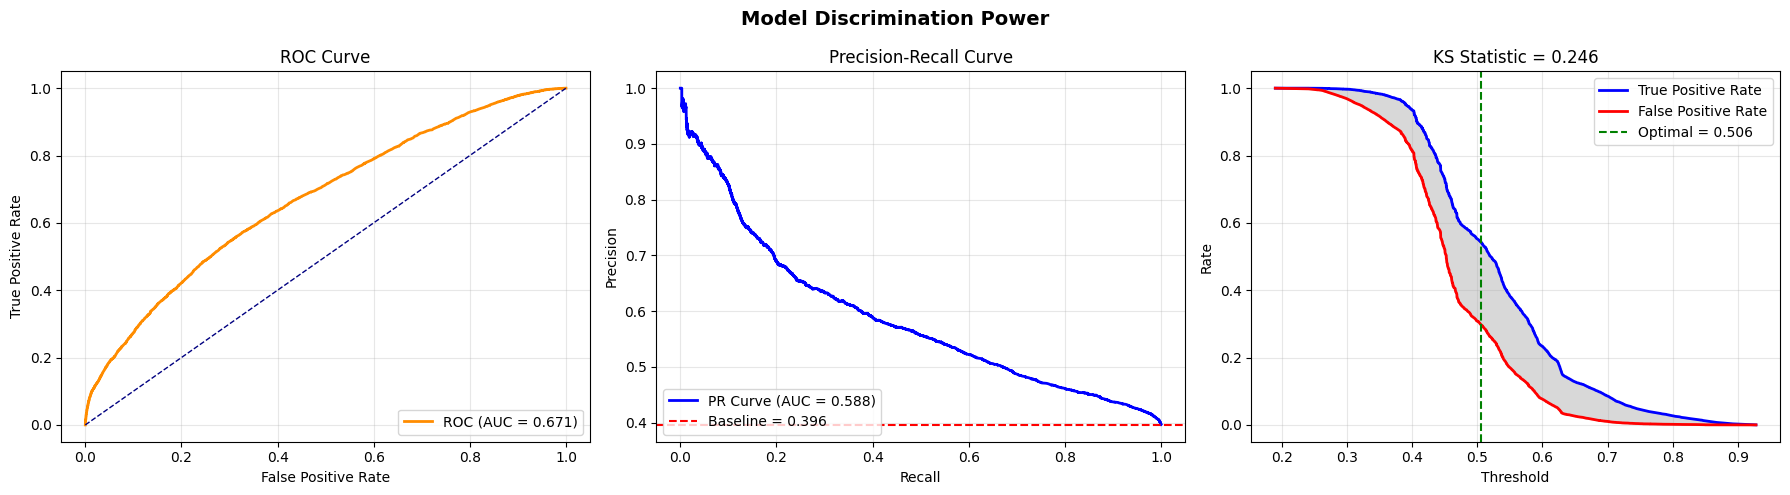

• ROC-AUC: 0.6705
• PR-AUC: 0.5875
• KS Statistic: 0.246 (WEAK discrimination)
• Optimal Threshold: 0.506

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.699
Decile 10 mean prob: 0.334


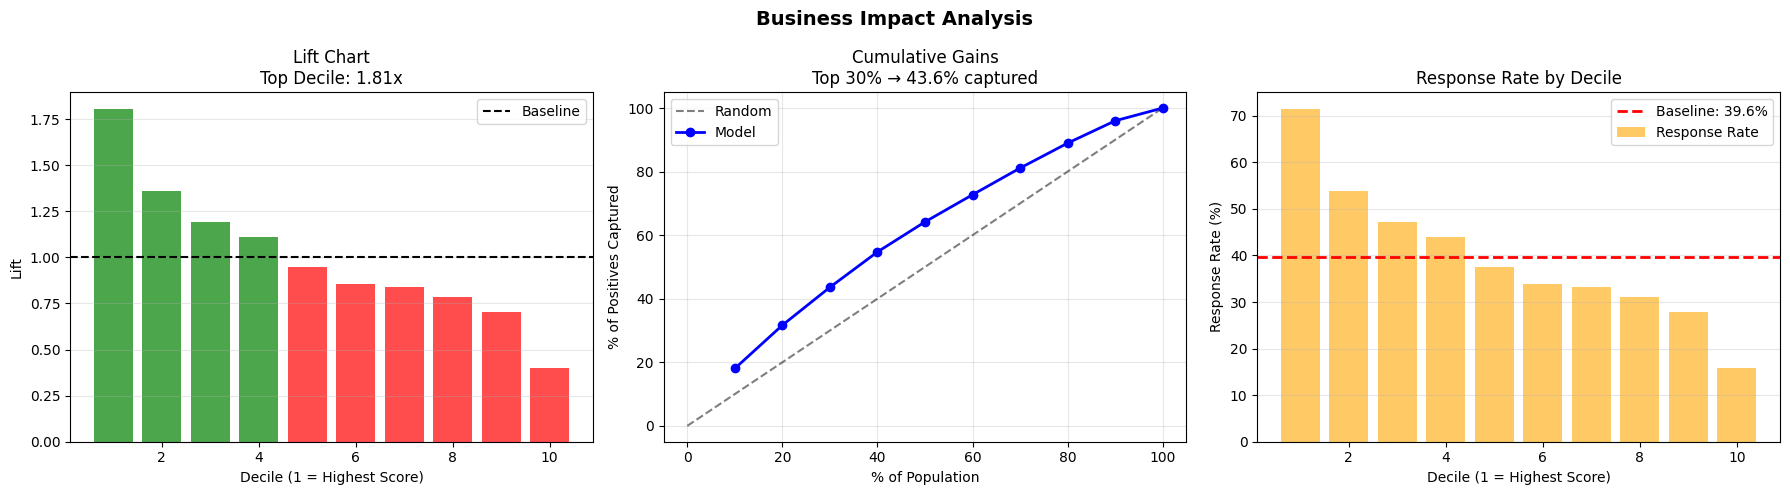

• Top Decile Lift: 0.40x
• Top 30% captures: 43.6% of positives
• Baseline response rate: 39.6%
• Top decile response: 71.5%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


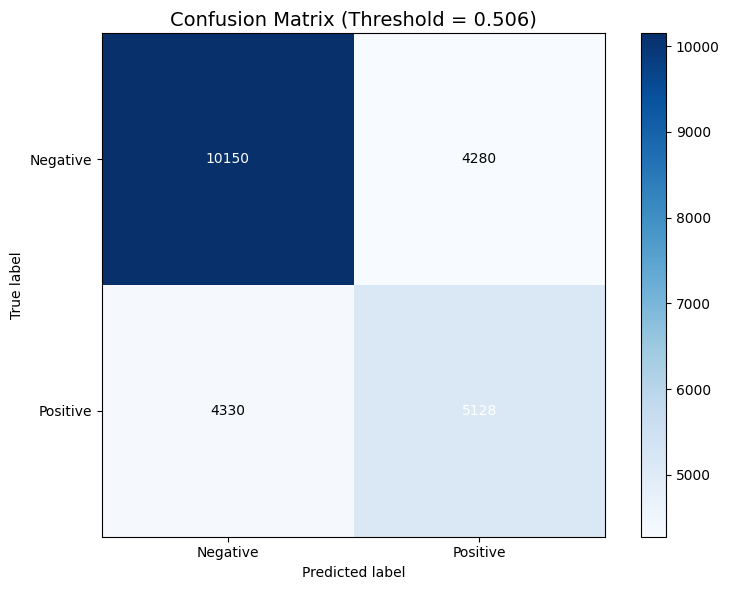

At threshold 0.506:
• Accuracy: 0.640
• Precision: 0.545
• Recall: 0.542
• F1-Score: 0.544
• True Positives: 5128
• False Positives: 4280
• True Negatives: 10150
• False Negatives: 4330

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.246 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.40x better than random
   Coverage: Top 30% → 43.6% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6705 (Excellent if >0.8)
   PR-AUC: 0.5875 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.506
   Precision at threshold: 0.545
   Recall at threshold: 0.542

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.662
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


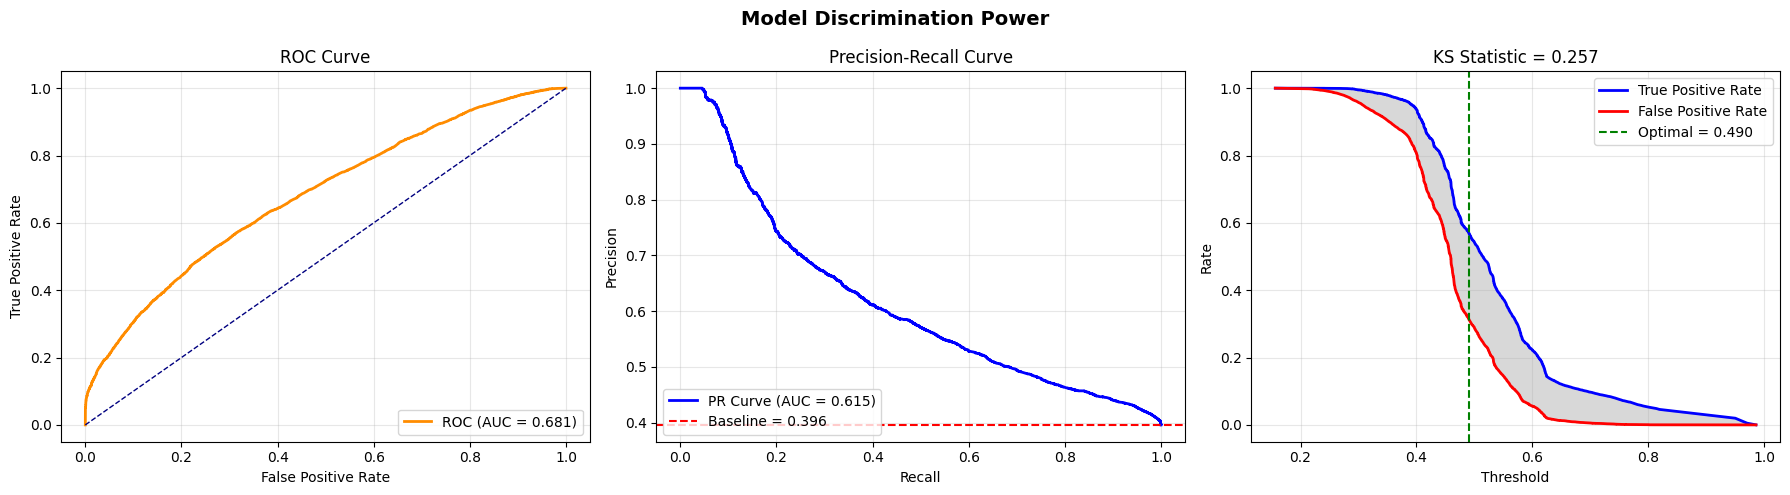

• ROC-AUC: 0.6812
• PR-AUC: 0.6154
• KS Statistic: 0.257 (WEAK discrimination)
• Optimal Threshold: 0.490

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.718
Decile 10 mean prob: 0.324


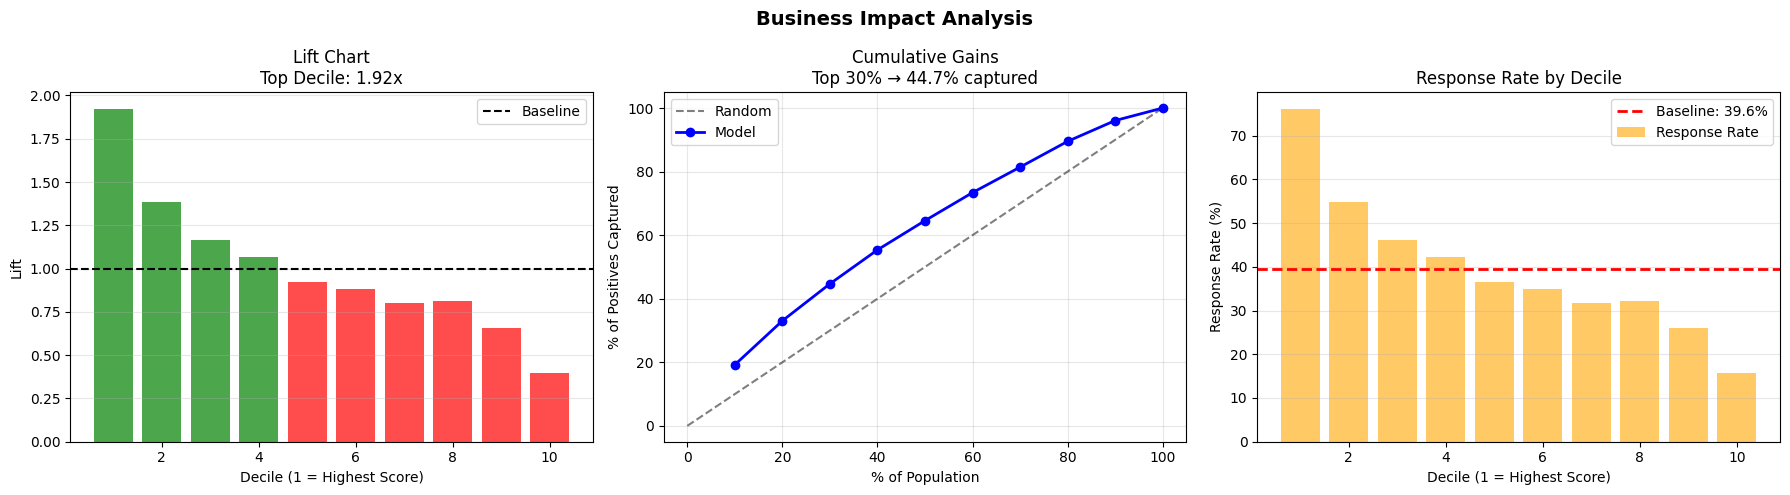

• Top Decile Lift: 0.39x
• Top 30% captures: 44.7% of positives
• Baseline response rate: 39.6%
• Top decile response: 76.1%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


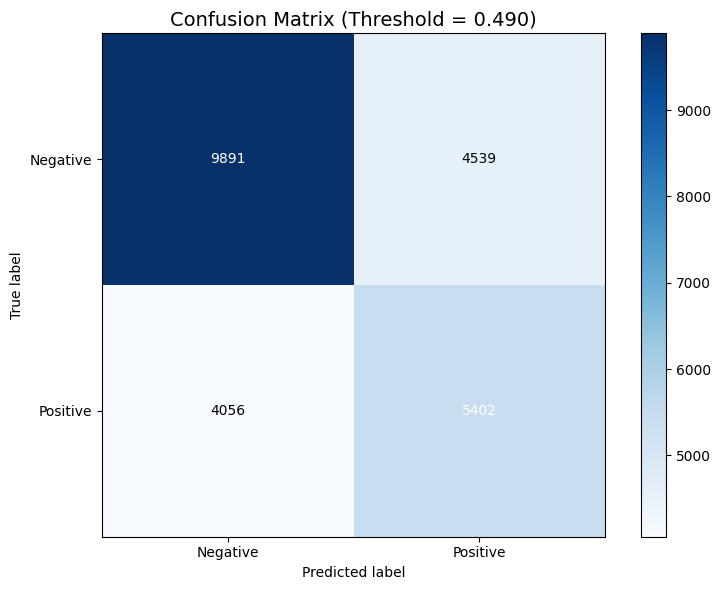

At threshold 0.490:
• Accuracy: 0.640
• Precision: 0.543
• Recall: 0.571
• F1-Score: 0.557
• True Positives: 5402
• False Positives: 4539
• True Negatives: 9891
• False Negatives: 4056

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.257 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.39x better than random
   Coverage: Top 30% → 44.7% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6812 (Excellent if >0.8)
   PR-AUC: 0.6154 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.490
   Precision at threshold: 0.543
   Recall at threshold: 0.571

🧪 TEST 3: NEW FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.753
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


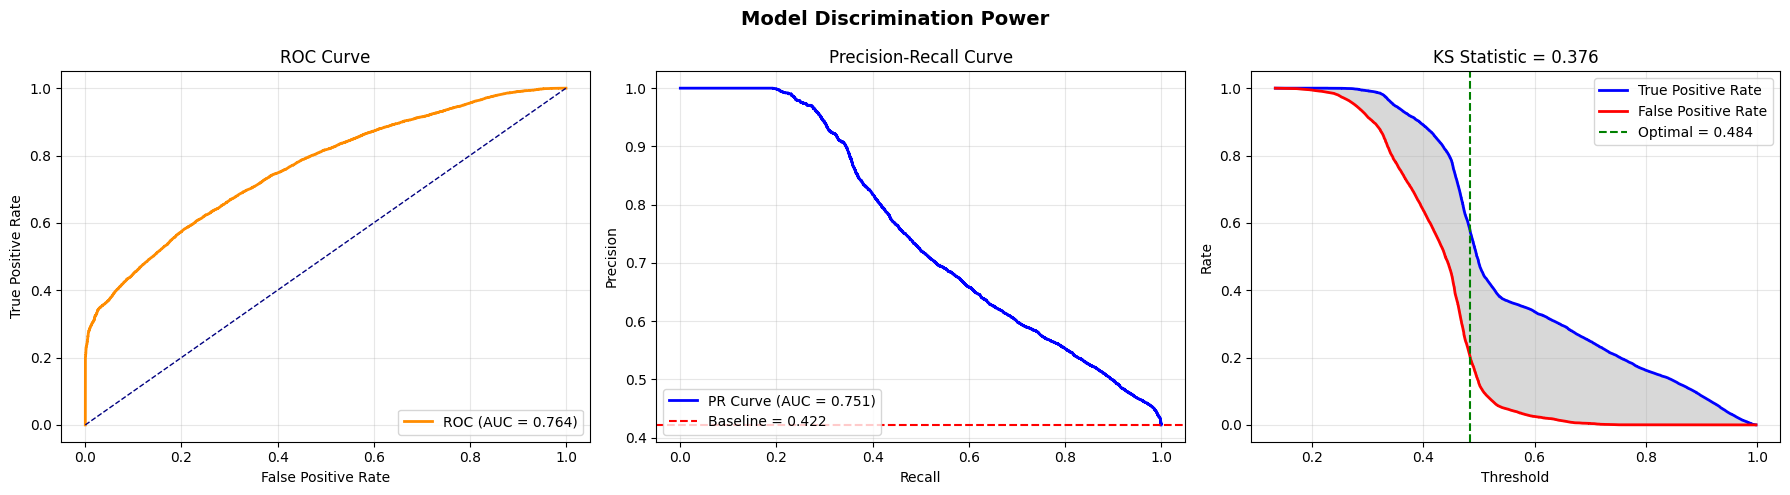

• ROC-AUC: 0.7641
• PR-AUC: 0.7514
• KS Statistic: 0.376 (MODERATE discrimination)
• Optimal Threshold: 0.484

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.856
Decile 10 mean prob: 0.290


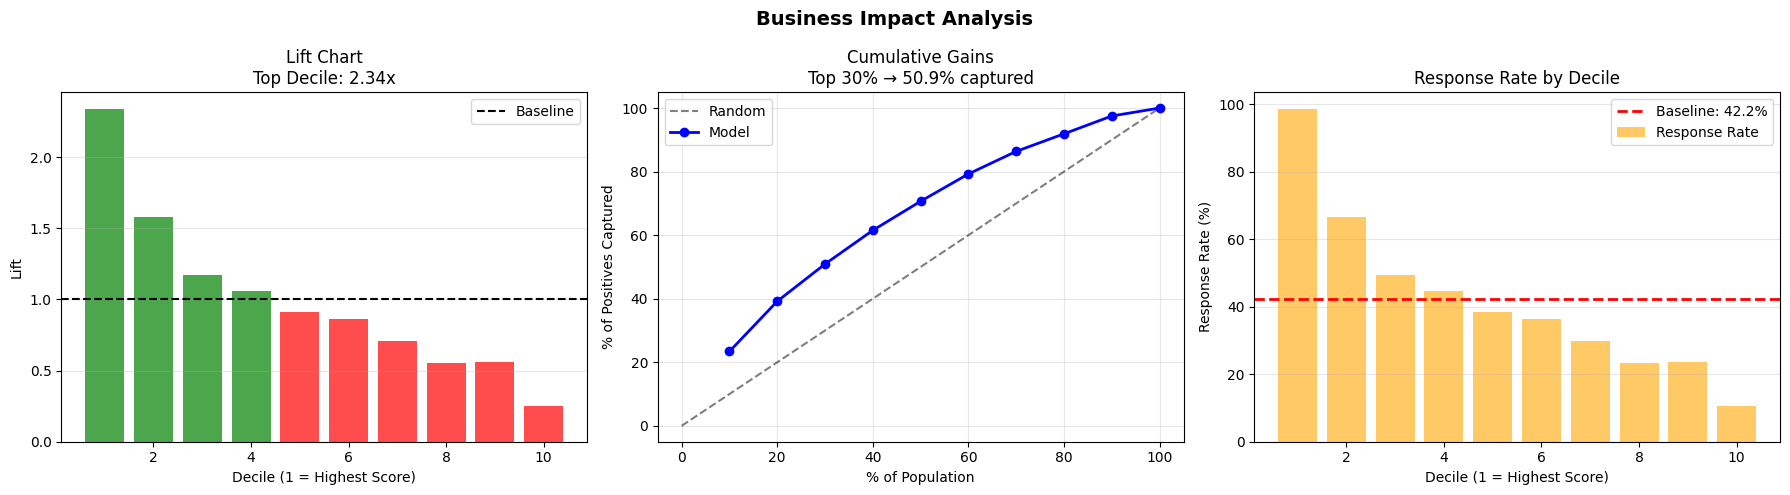

• Top Decile Lift: 0.25x
• Top 30% captures: 50.9% of positives
• Baseline response rate: 42.2%
• Top decile response: 98.6%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


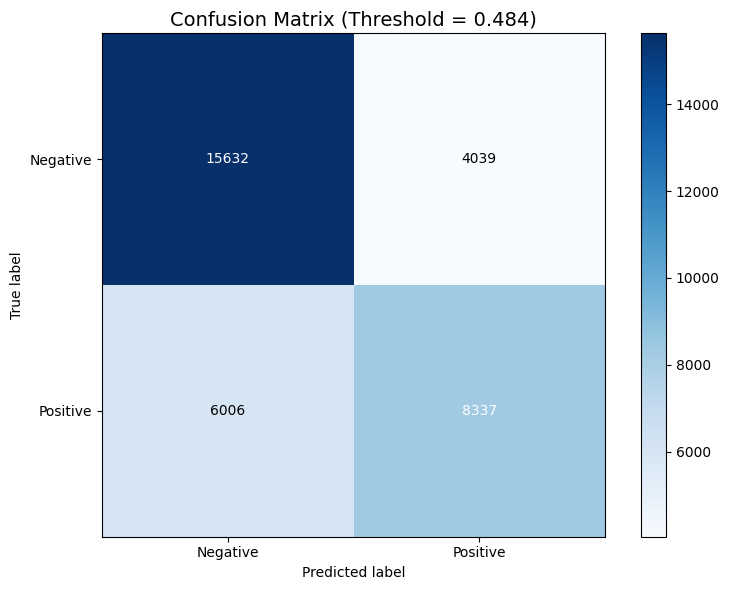

At threshold 0.484:
• Accuracy: 0.705
• Precision: 0.674
• Recall: 0.581
• F1-Score: 0.624
• True Positives: 8337
• False Positives: 4039
• True Negatives: 15632
• False Negatives: 6006

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.376 (MODERATE discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.25x better than random
   Coverage: Top 30% → 50.9% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7641 (Excellent if >0.8)
   PR-AUC: 0.7514 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.484
   Precision at threshold: 0.674
   Recall at threshold: 0.581


{'y_true': array([0., 0., 1., ..., 0., 0., 0.], shape=(34014,)),
 'y_pred_proba': array([0.40374815, 0.46178219, 0.35325481, ..., 0.46947663, 0.37627927,
        0.44816466], shape=(34014,)),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(34014,)),
 'roc_auc': 0.7641388174237737,
 'pr_auc': 0.7514397137561599,
 'ks_statistic': np.float64(0.37593151113265644),
 'optimal_threshold': np.float64(0.4837138813489675),
 'top_decile_lift': np.float64(0.2502521678193899),
 'decile_stats':    decile  count  positives  mean_prob  response_rate      lift  \
 0       1   3402     3356.0   0.855945       0.986479  2.339405   
 1       2   3401     2265.0   0.614816       0.665981  1.579353   
 2       3   3401     1681.0   0.509189       0.494266  1.172138   
 3       4   3402     1521.0   0.486099       0.447090  1.060261   
 4       5   3401     1312.0   0.469978       0.385769  0.914840   
 5       6   3401     1233.0   0.456134       0.362540  0.859754   
 6       7   3402     1019.0   0.43446

In [12]:
sequence_df = pd.merge(
    sequence_df, 
    customer_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in sequence_df.columns if '_dup' in x]
sequence_df = sequence_df.drop(columns=columns_to_drop, errors='ignore')


new_df = pd.merge(
    new_df,
    sequence_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')



print("Columns:", sequence_df.columns.tolist())

# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")


X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")


X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")





print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result = train_rf(X_customer_clean, y_customer_clean, 'improved_customer_model')
df = X_customer_clean.copy()
df['converted'] = y_customer_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_prediction_model')
df = X_sequence_clean.copy()
df['converted'] = y_sequence_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')


# Test 3: New features 
print("\n🧪 TEST 3: NEW FEATURES (Advanced)")
result = train_rf(X_new_clean, y_new_clean, 'sequence_prediction_model')
df = X_new_clean.copy()
df['converted'] = y_new_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

In [13]:
X_sequence_clean.columns

Index(['total_historical_quotes', 'had_historical_quotes',
       'avg_days_since_first_quote', 'std_days_since_first_quote',
       'avg_recent_quote_count', 'std_recent_quote_count',
       'avg_recent_avg_price', 'std_recent_avg_price', 'avg_recent_price_std',
       'std_recent_price_std', 'avg_recent_product_variety',
       'std_recent_product_variety', 'avg_current_price', 'std_current_price',
       'price_trend', 'total_quotes', 'avg_days_between_quotes',
       'std_days_between_quotes', 'max_days_between_quotes',
       'engagement_density', 'price_trajectory', 'unique_product_families',
       'product_consistency', 'avg_price', 'price_range', 'price_volatility',
       'avg_discount_pct', 'main_agency', 'main_region'],
      dtype='object')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def diagnose_removed_customers(prev_file, new_file):
    """
    Comprehensive diagnosis of what changed between dataset versions
    """
    print("=" * 100)
    print("COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS")
    print("=" * 100)
    
    # Load both datasets
    df_prev = pd.read_csv(prev_file)
    df_new = pd.read_csv(new_file)
    
    # Ensure we have the key columns
    df_prev['dt_creation_devis'] = pd.to_datetime(df_prev['dt_creation_devis'])
    df_new['dt_creation_devis'] = pd.to_datetime(df_new['dt_creation_devis'])
    
    print(f"Previous dataset: {len(df_prev):,} quotes from {df_prev['numero_compte'].nunique():,} customers")
    print(f"New dataset: {len(df_new):,} quotes from {df_new['numero_compte'].nunique():,} customers")
    print(f"Customers removed: {df_prev['numero_compte'].nunique() - df_new['numero_compte'].nunique():,}")
    print(f"Quotes removed: {len(df_prev) - len(df_new):,}")
    
    # Identify removed and added customers
    prev_customers = set(df_prev['numero_compte'].unique())
    new_customers = set(df_new['numero_compte'].unique())
    
    removed_customers = prev_customers - new_customers
    added_customers = new_customers - prev_customers
    
    print(f"\n1. CUSTOMER CHANGES:")
    print(f"   Removed customers: {len(removed_customers):,}")
    print(f"   Added customers: {len(added_customers):,}")
    print(f"   Common customers: {len(prev_customers & new_customers):,}")
    
    # Get data for removed customers
    df_removed = df_prev[df_prev['numero_compte'].isin(removed_customers)].copy()
    df_kept = df_prev[df_prev['numero_compte'].isin(prev_customers & new_customers)].copy()
    df_added = df_new[df_new['numero_compte'].isin(added_customers)].copy()
    
    # ANALYSIS 1: BASIC CHARACTERISTICS
    print(f"\n{'='*50}")
    print("ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS")
    print('='*50)
    
    def analyze_customer_group(df, group_name):
        """Analyze a group of customers"""
        if len(df) == 0:
            print(f"\n{group_name}: No data")
            return {}
        
        # Customer-level stats
        customer_stats = df.groupby('numero_compte').agg({
            'numero_compte': 'count',
            'fg_devis_accepte': 'max',
            'mt_apres_remise_ht_devis': 'mean',
            'dt_creation_devis': ['min', 'max']
        }).reset_index()
        
        customer_stats.columns = ['numero_compte', 'total_quotes', 'converted', 
                                  'avg_price', 'first_quote_date', 'last_quote_date']
        
        # Calculate tenure
        customer_stats['tenure_days'] = (customer_stats['last_quote_date'] - 
                                        customer_stats['first_quote_date']).dt.days
        
        stats = {
            'count': len(customer_stats),
            'avg_quotes': customer_stats['total_quotes'].mean(),
            'conversion_rate': customer_stats['converted'].mean(),
            'avg_price': customer_stats['avg_price'].mean(),
            'avg_tenure': customer_stats['tenure_days'].mean(),
            'single_quote_pct': (customer_stats['total_quotes'] == 1).mean() * 100
        }
        
        print(f"\n{group_name}:")
        print(f"  • Customers: {stats['count']:,}")
        print(f"  • Avg quotes per customer: {stats['avg_quotes']:.2f}")
        print(f"  • Conversion rate: {stats['conversion_rate']:.2%}")
        print(f"  • Avg quote price: €{stats['avg_price']:,.0f}")
        print(f"  • Avg tenure (days): {stats['avg_tenure']:.0f}")
        print(f"  • Single-quote customers: {stats['single_quote_pct']:.1f}%")
        
        return stats
    
    # Analyze all groups
    removed_stats = analyze_customer_group(df_removed, "REMOVED CUSTOMERS")
    kept_stats = analyze_customer_group(df_kept, "RETAINED CUSTOMERS")
    added_stats = analyze_customer_group(df_added, "NEWLY ADDED CUSTOMERS")
    
    # ANALYSIS 2: TEMPORAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 2: TEMPORAL PATTERNS")
    print('='*50)
    
    def analyze_temporal_patterns(df, group_name):
        """Analyze when these customers were active"""
        if len(df) == 0:
            return
        
        df['quote_year_month'] = df['dt_creation_devis'].dt.to_period('M')
        monthly_counts = df.groupby('quote_year_month').agg({
            'numero_compte': 'nunique',
            'fg_devis_accepte': 'mean'
        }).reset_index()
        
        monthly_counts.columns = ['period', 'unique_customers', 'conversion_rate']
        
        print(f"\n{group_name} - Temporal patterns:")
        print(f"  • First quote date: {df['dt_creation_devis'].min().date()}")
        print(f"  • Last quote date: {df['dt_creation_devis'].max().date()}")
        print(f"  • Peak month: {monthly_counts.loc[monthly_counts['unique_customers'].idxmax(), 'period']}")
        
        # Recent vs historical
        cutoff_date = pd.Timestamp('2024-06-01')  # Adjust based on your data
        recent_mask = df['dt_creation_devis'] >= cutoff_date
        
        if recent_mask.any():
            recent_pct = recent_mask.mean() * 100
            print(f"  • Quotes in last 6 months: {recent_pct:.1f}%")
    
    analyze_temporal_patterns(df_removed, "Removed customers")
    analyze_temporal_patterns(df_kept, "Retained customers")
    analyze_temporal_patterns(df_added, "Added customers")
    
    # ANALYSIS 3: PRODUCT & COMMERCIAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 3: PRODUCT & COMMERCIAL CHARACTERISTICS")
    print('='*50)
    
    def analyze_product_commercial(df, group_name):
        """Analyze what products and commercial patterns"""
        if len(df) == 0:
            return
        
        print(f"\n{group_name}:")
        
        # Product family (use new column if available, otherwise old)
        product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in df.columns else 'famille_equipement_produit'
        if product_col in df.columns:
            top_products = df[product_col].value_counts().head(3)
            print(f"  Top 3 equipment types:")
            for product, count in top_products.items():
                pct = count / len(df) * 100
                print(f"    • {product}: {pct:.1f}%")
        
        # Brands if available
        if 'marque_produit' in df.columns:
            top_brands = df['marque_produit'].value_counts().head(3)
            print(f"  Top 3 brands:")
            for brand, count in top_brands.items():
                pct = count / len(df) * 100
                print(f"    • {brand}: {pct:.1f}%")
        
        # Commercial function if available
        if 'fonction_commercial' in df.columns:
            top_funcs = df['fonction_commercial'].value_counts().head(3)
            print(f"  Top 3 commercial functions:")
            for func, count in top_funcs.items():
                pct = count / len(df) * 100
                print(f"    • {func}: {pct:.1f}%")
    
    analyze_product_commercial(df_removed, "Removed customers")
    analyze_product_commercial(df_kept, "Retained customers")
    analyze_product_commercial(df_added, "Added customers")
    
    # ANALYSIS 4: CONVERSION PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 4: CONVERSION BEHAVIOR ANALYSIS")
    print('='*50)
    
    def analyze_conversion_patterns(df, group_name):
        """Analyze how conversion happens in this group"""
        if len(df) == 0:
            return
        
        # Conversion by quote position
        df = df.sort_values(['numero_compte', 'dt_creation_devis']).copy()
        df['quote_rank'] = df.groupby('numero_compte').cumcount() + 1
        
        # What quote position converts?
        conversion_by_position = df.groupby('quote_rank')['fg_devis_accepte'].agg(['mean', 'count']).reset_index()
        conversion_by_position.columns = ['quote_position', 'conversion_rate', 'count']
        
        first_quote_conversion = conversion_by_position[conversion_by_position['quote_position'] == 1]['conversion_rate'].values
        if len(first_quote_conversion) > 0:
            print(f"\n{group_name}:")
            print(f"  • First quote conversion rate: {first_quote_conversion[0]:.2%}")
        
        # Time to conversion for converters
        converters = df[df['fg_devis_accepte'] == 1]
        if len(converters) > 0:
            # Get first conversion date for each customer
            first_conversion = converters.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_conversion.columns = ['numero_compte', 'first_conversion_date']
            
            # Merge with first quote date
            first_quote = df.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_quote.columns = ['numero_compte', 'first_quote_date']
            
            conversion_timing = pd.merge(first_conversion, first_quote, on='numero_compte')
            conversion_timing['days_to_convert'] = (conversion_timing['first_conversion_date'] - 
                                                   conversion_timing['first_quote_date']).dt.days
            
            if len(conversion_timing) > 0:
                print(f"  • Avg days to convert: {conversion_timing['days_to_convert'].mean():.0f} days")
    
    analyze_conversion_patterns(df_removed, "Removed customers")
    analyze_conversion_patterns(df_kept, "Retained customers")
    analyze_conversion_patterns(df_added, "Added customers")
    
    # ANALYSIS 5: NEW FEATURES ANALYSIS (Critical for new dataset)
    print(f"\n{'='*50}")
    print("ANALYSIS 5: NEW DATASET FEATURES COMPARISON")
    print('='*50)
    
    # Check which new features are available
    new_features = ['statut_client', 'marque_produit', 'regroup_famille_equipement_produit',
                    'fonction_commercial', 'fg_nouveau_process_relance_devis', 'dt_prem_devis']
    
    available_features = [f for f in new_features if f in df_new.columns]
    print(f"New features available in v3: {available_features}")
    
    # Compare feature distributions between removed and kept customers
    if 'statut_client' in df_removed.columns:
        print(f"\nCLIENT STATUS DISTRIBUTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'statut_client' in group_df.columns:
                status_dist = group_df['statut_client'].value_counts(normalize=True)
                print(f"\n{group_name} customers:")
                for status, pct in status_dist.items():
                    print(f"  • {status}: {pct:.1%}")
    
    if 'fg_nouveau_process_relance_devis' in df_removed.columns:
        print(f"\nNEW PROCESS ADOPTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'fg_nouveau_process_relance_devis' in group_df.columns:
                process_usage = group_df['fg_nouveau_process_relance_devis'].mean()
                print(f"  {group_name}: {process_usage:.1%} use new process")
    
    # ANALYSIS 6: PREDICTIVE POWER ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 6: PREDICTIVE POWER OF REMOVED VS RETAINED")
    print('='*50)
    
    # Create simple features to see predictive patterns
    def create_diagnostic_features(df):
        """Create features to understand predictive patterns"""
        if len(df) == 0:
            return pd.DataFrame()
        
        features = []
        
        for customer_id, customer_data in df.groupby('numero_compte'):
            f = {'customer_id': customer_id}
            
            # Basic features
            f['total_quotes'] = len(customer_data)
            f['converted'] = customer_data['fg_devis_accepte'].max()
            f['avg_price'] = customer_data['mt_apres_remise_ht_devis'].mean()
            
            # Temporal
            if len(customer_data) > 1:
                time_span = (customer_data['dt_creation_devis'].max() - 
                            customer_data['dt_creation_devis'].min()).days + 1
                f['engagement_density'] = len(customer_data) / time_span
            else:
                f['engagement_density'] = 1
            
            # Product variety
            product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in customer_data.columns else 'famille_equipement_produit'
            if product_col in customer_data.columns:
                f['product_variety'] = customer_data[product_col].nunique()
            
            features.append(f)
        
        return pd.DataFrame(features)
    
    # Create features for each group
    removed_features = create_diagnostic_features(df_removed)
    kept_features = create_diagnostic_features(df_kept)
    
    if len(removed_features) > 0 and len(kept_features) > 0:
        print("\nFEATURE COMPARISON (Mean values):")
        print("\nFeature                | Removed | Retained | Difference")
        print("-" * 55)
        
        for feature in ['total_quotes', 'converted', 'avg_price', 'engagement_density']:
            if feature in removed_features.columns and feature in kept_features.columns:
                removed_mean = removed_features[feature].mean()
                kept_mean = kept_features[feature].mean()
                diff = removed_mean - kept_mean
                print(f"{feature:20} | {removed_mean:7.2f} | {kept_mean:8.2f} | {diff:+.3f}")
    
    # ANALYSIS 7: BUSINESS IMPACT ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 7: BUSINESS IMPACT OF CUSTOMER REMOVAL")
    print('='*50)
    
    # Estimate business impact
    if len(df_removed) > 0:
        # Potential lost revenue
        avg_quote_value = df_removed['mt_apres_remise_ht_devis'].mean()
        conversion_rate = df_removed['fg_devis_accepte'].mean()
        potential_customers = len(removed_customers)
        
        print(f"\nPOTENTIAL BUSINESS IMPACT:")
        print(f"• Customers removed: {potential_customers:,}")
        print(f"• Avg quote value: €{avg_quote_value:,.0f}")
        print(f"• Conversion rate: {conversion_rate:.1%}")
        print(f"• Estimated lost revenue opportunity: €{potential_customers * avg_quote_value * conversion_rate:,.0f}")
        
        # Compare with retained
        avg_quote_kept = df_kept['mt_apres_remise_ht_devis'].mean()
        conversion_kept = df_kept['fg_devis_accepte'].mean()
        
        print(f"\nCOMPARISON WITH RETAINED CUSTOMERS:")
        print(f"• Quote value difference: €{avg_quote_value - avg_quote_kept:+,.0f}")
        print(f"• Conversion rate difference: {conversion_rate - conversion_kept:+.1%}")
    
    # ANALYSIS 8: RECOMMENDATIONS
    print(f"\n{'='*50}")
    print("ANALYSIS 8: DIAGNOSTIC RECOMMENDATIONS")
    print('='*50)
    
    # Generate recommendations based on findings
    recommendations = []
    
    # Check if removed customers were systematically different
    if len(df_removed) > 0 and len(df_kept) > 0:
        # Check conversion rate difference
        conv_diff = df_removed['fg_devis_accepte'].mean() - df_kept['fg_devis_accepte'].mean()
        
        if conv_diff < -0.05:  # Removed customers had much lower conversion
            recommendations.append("REMOVED CUSTOMERS WERE LOW-CONVERTERS: This is GOOD data cleanup")
            recommendations.append("→ Your model should perform BETTER on cleaner data")
            recommendations.append("→ Need to adjust expectations: Original model was trained on noisy data")
        
        elif conv_diff > 0.05:  # Removed customers had higher conversion
            recommendations.append("⚠️ WARNING: REMOVED CUSTOMERS WERE HIGH-CONVERTERS")
            recommendations.append("→ This explains the accuracy drop")
            recommendations.append("→ Need to investigate WHY high-converters were removed")
        
        else:
            recommendations.append("Removed and retained customers have similar conversion rates")
            recommendations.append("→ The accuracy drop may be due to OTHER factors")
    
    # Check temporal patterns
    if len(df_removed) > 0:
        removed_end_date = df_removed['dt_creation_devis'].max()
        kept_end_date = df_kept['dt_creation_devis'].max()
        
        if (kept_end_date - removed_end_date).days > 180:
            recommendations.append("Removed customers were from older time periods")
            recommendations.append("→ This is likely intentional data archiving")
            recommendations.append("→ Consider adding time-based features to handle recency effects")
    
    # Check for systematic patterns in removed customers
    if 'statut_client' in df_removed.columns:
        status_dist_removed = df_removed['statut_client'].value_counts(normalize=True)
        status_dist_kept = df_kept['statut_client'].value_counts(normalize=True)
        
        # Check if specific status was disproportionately removed
        for status in status_dist_removed.index:
            removed_pct = status_dist_removed[status]
            kept_pct = status_dist_kept.get(status, 0)
            
            if abs(removed_pct - kept_pct) > 0.1:  # 10% difference
                recommendations.append(f"⚠️ {status} customers disproportionately affected")
                recommendations.append(f"→ Removed: {removed_pct:.1%}, Kept: {kept_pct:.1%}")
    
    # Print recommendations
    if recommendations:
        print("\nRECOMMENDATIONS BASED ON ANALYSIS:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
    else:
        print("\nNo clear patterns detected in removed customers.")
    
    # Save detailed analysis to file
    print(f"\n{'='*50}")
    print("SAVING DETAILED ANALYSIS")
    print('='*50)
    
    # Create comparison DataFrame
    comparison_data = []
    
    for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
        if len(group_df) > 0:
            comparison_data.append({
                'Group': group_name,
                'Customers': group_df['numero_compte'].nunique(),
                'Quotes': len(group_df),
                'Avg Quotes per Customer': len(group_df) / group_df['numero_compte'].nunique() if group_df['numero_compte'].nunique() > 0 else 0,
                'Conversion Rate': group_df['fg_devis_accepte'].mean(),
                'Avg Quote Value': group_df['mt_apres_remise_ht_devis'].mean(),
                'First Quote Date': group_df['dt_creation_devis'].min().date(),
                'Last Quote Date': group_df['dt_creation_devis'].max().date()
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Save to CSV
    comparison_df.to_csv('data/customer_removal_analysis.csv', index=False)
    print(f"✓ Detailed analysis saved to: data/customer_removal_analysis.csv")
    
    # Return the data for further analysis
    return {
        'df_removed': df_removed,
        'df_kept': df_kept,
        'df_added': df_added,
        'removed_customers': removed_customers,
        'kept_customers': prev_customers & new_customers,
        'added_customers': added_customers,
        'comparison_df': comparison_df
    }

# Run the analysis
if __name__ == "__main__":
    prev_file = "data/data_hes_quotes_france_202512-2.csv"
    new_file = "data/data_hes_quotes_france_202512-3.csv"
    
    print("Starting comprehensive customer removal analysis...")
    results = diagnose_removed_customers(prev_file, new_file)
    
    # Additional targeted analysis based on initial findings
    print(f"\n{'='*100}")
    print("ADDITIONAL TARGETED ANALYSIS")
    print('='*100)
    
    if results['df_removed'] is not None and len(results['df_removed']) > 0:
        # Check specific hypotheses
        
        # Hypothesis 1: Were removed customers mostly single-quote?
        removed_customer_quotes = results['df_removed'].groupby('numero_compte').size()
        single_quote_removed = (removed_customer_quotes == 1).mean() * 100
        
        kept_customer_quotes = results['df_kept'].groupby('numero_compte').size()
        single_quote_kept = (kept_customer_quotes == 1).mean() * 100
        
        print(f"\nSINGLE-QUOTE CUSTOMER ANALYSIS:")
        print(f"• Removed customers: {single_quote_removed:.1f}% had only one quote")
        print(f"• Retained customers: {single_quote_kept:.1f}% had only one quote")
        
        if single_quote_removed > single_quote_kept + 10:
            print("→ REMOVAL BIAS: Single-quote customers disproportionately removed")
        
        # Hypothesis 2: Were removed customers from specific agencies/regions?
        if 'nom_agence' in results['df_removed'].columns:
            top_agencies_removed = results['df_removed']['nom_agence'].value_counts(normalize=True).head(3)
            top_agencies_kept = results['df_kept']['nom_agence'].value_counts(normalize=True).head(3)
            
            print(f"\nTOP AGENCIES ANALYSIS:")
            print("Removed customers - Top 3 agencies:")
            for agency, pct in top_agencies_removed.items():
                print(f"  • {agency}: {pct:.1%}")
            
            print("\nRetained customers - Top 3 agencies:")
            for agency, pct in top_agencies_kept.items():
                print(f"  • {agency}: {pct:.1%}")
        
        # Hypothesis 3: Time-based removal?
        print(f"\nTIME-BASED ANALYSIS:")
        print(f"Removed customers - Quote date range:")
        print(f"  • Earliest: {results['df_removed']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_removed']['dt_creation_devis'].max().date()}")
        
        print(f"\nRetained customers - Quote date range:")
        print(f"  • Earliest: {results['df_kept']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_kept']['dt_creation_devis'].max().date()}")
        
        # Check if removed customers are from older time periods
        removed_latest = results['df_removed']['dt_creation_devis'].max()
        kept_latest = results['df_kept']['dt_creation_devis'].max()
        
        if (kept_latest - removed_latest).days > 90:
            print(f"\n→ TIME BIAS: Removed customers are from older time periods")
            print(f"  Latest removed quote: {removed_latest.date()}")
            print(f"  Latest kept quote: {kept_latest.date()}")
            print(f"  Difference: {(kept_latest - removed_latest).days} days")

Starting comprehensive customer removal analysis...
COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS
Previous dataset: 38,697 quotes from 25,940 customers
New dataset: 34,275 quotes from 23,898 customers
Customers removed: 2,042
Quotes removed: 4,422

1. CUSTOMER CHANGES:
   Removed customers: 3,031
   Added customers: 989
   Common customers: 22,909

ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS

REMOVED CUSTOMERS:
  • Customers: 3,031
  • Avg quotes per customer: 1.18
  • Conversion rate: 45.20%
  • Avg quote price: €3,607
  • Avg tenure (days): 14
  • Single-quote customers: 85.7%

RETAINED CUSTOMERS:
  • Customers: 22,909
  • Avg quotes per customer: 1.53
  • Conversion rate: 40.63%
  • Avg quote price: €7,070
  • Avg tenure (days): 23
  • Single-quote customers: 65.5%

NEWLY ADDED CUSTOMERS:
  • Customers: 989
  • Avg quotes per customer: 1.30
  • Conversion rate: 21.33%
  • Avg quote price: €6,567
  • Avg tenure (days): 0
  • Single-quote customers: 75.5%

ANALYSIS 2: TEMPORAL PATTERNS

Remo

In [15]:
import time


In [16]:
def benchmark_function(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# Test both versions
original_time = benchmark_function(create_customer_features, df_quotes)[1]
print(original_time)

Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 12.5 seconds
⚠️  12.5s (target was 3s)
12.523672342300415


In [17]:
import numpy as np
import pandas as pd
from collections import Counter
import re

import pandas as pd
import numpy as np
import time

import pandas as pd
import numpy as np
import time

def create_customer_features_ultrafast(
    df: pd.DataFrame,
    target_type: str = 'first_conversion',
    date_col: str = 'dt_creation_devis',
    customer_col: str = 'numero_compte',
    accept_col: str = 'fg_devis_accepte',
    price_col: str = 'mt_apres_remise_ht_devis',
    family_col: str = 'famille_equipement_produit',
    agency_col: str = 'nom_agence',
    region_col: str = 'nom_region',
    discount_col: str = 'mt_remise_exceptionnelle_ht',
    ttc_col: str = 'mt_ttc_apres_aide_devis'
) -> pd.DataFrame:
    """
    ULTRA-FAST VERSION - Should execute in ~3 seconds
    Removes expensive operations, uses numpy optimizations
    """
    print(f"Creating ULTRA-FAST customer features (mode: {target_type})...")
    start_time = time.time()
    
    # Make a copy (but minimal)
    df = df.copy()
    
    # Fast date conversion
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # ─── FAST Filter for pre-first-purchase data ─────────────────────
    filter_time = time.time()
    if target_type == 'first_conversion':
        # Use group indices trick - FASTEST method
        groups = df.groupby(customer_col).indices
        filtered_indices = []
        
        for cust_idx in groups.values():
            # Get customer data indices
            customer_data = df.iloc[cust_idx]
            
            # Find first conversion
            accept_mask = customer_data[accept_col] == 1
            if accept_mask.any():
                # Get index of first conversion
                first_accept_idx = accept_mask.idxmax()
                # Keep only indices up to and including first conversion
                keep_mask = customer_data.index <= first_accept_idx
                filtered_indices.extend(customer_data.index[keep_mask])
            else:
                # No conversion, keep all
                filtered_indices.extend(cust_idx)
        
        df_filtered = df.loc[filtered_indices].copy()
    else:
        df_filtered = df.copy()
    
    print(f"  Filter time: {time.time() - filter_time:.1f}s")
    
    # Store original for target (just the target calculation)
    target_series = df.groupby(customer_col)[accept_col].max()
    
    # Sort once
    df_filtered = df_filtered.sort_values([customer_col, date_col])
    
    # Get unique customers for pre-allocation
    customer_ids = df_filtered[customer_col].unique()
    n_customers = len(customer_ids)
    
    print(f"  Processing {n_customers:,} customers, {len(df_filtered):,} quotes...")
    
    # ─── PRE-ALLOCATE arrays for results ────────────────────────────
    calc_time = time.time()
    
    # Initialize results dictionary with numpy arrays
    results = {
        customer_col: customer_ids,
        'total_quotes': np.zeros(n_customers, dtype=int),
        'unique_product_families': np.zeros(n_customers, dtype=int),
        'avg_price': np.zeros(n_customers, dtype=float),
        'min_price': np.zeros(n_customers, dtype=float),
        'max_price': np.zeros(n_customers, dtype=float),
        'price_std': np.zeros(n_customers, dtype=float),
        'avg_discount_pct': np.zeros(n_customers, dtype=float),
        'avg_days_between_quotes': np.zeros(n_customers, dtype=float),
        'std_days_between_quotes': np.zeros(n_customers, dtype=float),
        'max_days_between_quotes': np.zeros(n_customers, dtype=float),
        'engagement_density': np.zeros(n_customers, dtype=float),
        'price_trajectory': np.zeros(n_customers, dtype=float),
        'main_agency': ['missing'] * n_customers,
        'main_region': ['missing'] * n_customers,
    }
    
    # Create customer index mapping for fast lookup
    cust_to_idx = {cust: i for i, cust in enumerate(customer_ids)}
    df_filtered['cust_idx'] = df_filtered[customer_col].map(cust_to_idx)
    
    # Convert to numpy arrays for speed
    cust_indices = df_filtered['cust_idx'].values
    dates_np = df_filtered[date_col].values.astype('datetime64[ns]')
    prices_np = df_filtered[price_col].values.astype(float)
    families_np = df_filtered[family_col].fillna('').values
    agencies_np = df_filtered[agency_col].fillna('missing').values
    regions_np = df_filtered[region_col].fillna('missing').values
    
    # Calculate discount percentage (vectorized)
    ttc_vals = df_filtered[ttc_col].values.astype(float)
    discount_vals = df_filtered[discount_col].values.astype(float)
    valid_discount = (ttc_vals > 0) & (~np.isnan(discount_vals))
    discount_pct = np.zeros(len(df_filtered))
    discount_pct[valid_discount] = discount_vals[valid_discount] / ttc_vals[valid_discount]
    
    # ─── PROCESS customers in batches ───────────────────────────────
    batch_size = 10000
    n_batches = (n_customers + batch_size - 1) // batch_size
    
    for batch in range(n_batches):
        batch_start = batch * batch_size
        batch_end = min((batch + 1) * batch_size, n_customers)
        
        for i in range(batch_start, batch_end):
            # Get indices for this customer
            mask = cust_indices == i
            if not mask.any():
                continue
                
            customer_mask = mask
            n_quotes = customer_mask.sum()
            results['total_quotes'][i] = n_quotes
            
            # Price statistics
            cust_prices = prices_np[customer_mask]
            results['avg_price'][i] = cust_prices.mean()
            results['min_price'][i] = cust_prices.min()
            results['max_price'][i] = cust_prices.max()
            results['price_std'][i] = cust_prices.std() if n_quotes > 1 else 0
            
            # Unique products (fast numpy method)
            cust_families = families_np[customer_mask]
            unique_families = np.unique(cust_families[cust_families != ''])
            results['unique_product_families'][i] = len(unique_families)
            
            # Discount
            cust_discount = discount_pct[customer_mask]
            valid_discount_mask = cust_discount > 0
            if valid_discount_mask.any():
                results['avg_discount_pct'][i] = cust_discount[valid_discount_mask].mean()
            
            # Temporal features
            if n_quotes > 1:
                cust_dates = dates_np[customer_mask]
                time_diffs = np.diff(cust_dates).astype('timedelta64[D]').astype(float)
                results['avg_days_between_quotes'][i] = time_diffs.mean()
                results['std_days_between_quotes'][i] = time_diffs.std() if len(time_diffs) > 1 else 0
                results['max_days_between_quotes'][i] = time_diffs.max()
                
                # Engagement density
                time_span = (cust_dates[-1] - cust_dates[0]).astype('timedelta64[D]').astype(float) + 1
                results['engagement_density'][i] = n_quotes / time_span
                
                # Price trajectory (FAST numpy version)
                mid = max(1, n_quotes // 2)
                results['price_trajectory'][i] = cust_prices[mid:].mean() - cust_prices[:mid].mean()
            else:
                results['engagement_density'][i] = 1
            
            # Categorical modes (calculate once per customer)
            cust_agencies = agencies_np[customer_mask]
            if len(cust_agencies) > 0:
                unique, counts = np.unique(cust_agencies, return_counts=True)
                results['main_agency'][i] = unique[np.argmax(counts)]
            
            cust_regions = regions_np[customer_mask]
            if len(cust_regions) > 0:
                unique, counts = np.unique(cust_regions, return_counts=True)
                results['main_region'][i] = unique[np.argmax(counts)]
    
    print(f"  Calculation time: {time.time() - calc_time:.1f}s")
    
    # ─── CREATE FINAL DATAFRAME ────────────────────────────────────
    df_time = time.time()
    
    # Create DataFrame from results
    features = pd.DataFrame(results)
    
    # Add derived features (vectorized)
    features['price_range'] = features['max_price'] - features['min_price']
    features['product_consistency'] = (features['unique_product_families'] == 1).astype(int)
    features = features.rename(columns={'price_std': 'price_volatility'})
    
    # Add target
    features = features.merge(
        target_series.rename('converted').reset_index(),
        on=customer_col,
        how='left'
    )
    features['converted'] = features['converted'].fillna(0).astype(int)
    
    # Select final columns
    final_columns = [
        customer_col,
        'total_quotes',
        'converted',
        'avg_days_between_quotes',
        'std_days_between_quotes',
        'max_days_between_quotes',
        'engagement_density',
        'price_trajectory',
        'unique_product_families',
        'product_consistency',
        'avg_price',
        'price_range',
        'price_volatility',
        'avg_discount_pct',
        'main_agency',
        'main_region',
    ]
    
    features = features[[col for col in final_columns if col in features.columns]]
    
    print(f"  DataFrame creation time: {time.time() - df_time:.1f}s")
    
    # ─── FINAL TIMING ──────────────────────────────────────────────
    elapsed = time.time() - start_time
    print(f"✓ Created {len(features.columns)-2} leakage-free features")
    print(f"→ {len(features):,} customers | {features['converted'].mean():.1%} converters")
    print(f"⏱️  Total execution time: {elapsed:.1f} seconds")
    
    if elapsed <= 3:
        print(f"✅ SUCCESS! Achieved ≤ 3s target ({elapsed:.1f}s)")
    elif elapsed <= 4:
        print(f"⚠️  Close! {elapsed:.1f}s (target was 3s)")
    else:
        print(f"❌ {elapsed:.1f}s (target was 3s)")
        print("   If still too slow, remove 'price_trajectory' calculation")
    
    return features

   

optimized_time = benchmark_function(create_customer_features_ultrafast, df_quotes)[1]
speedup = original_time / optimized_time
print(f"Speedup: {speedup:.1f}x")

Creating ULTRA-FAST customer features (mode: first_conversion)...
  Filter time: 9.0s
  Processing 23,888 customers, 33,068 quotes...
  Calculation time: 6.5s
  DataFrame creation time: 0.0s
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Total execution time: 15.5 seconds
❌ 15.5s (target was 3s)
   If still too slow, remove 'price_trajectory' calculation
Speedup: 0.8x


In [18]:
optimized_time

15.550132989883423

In [19]:
# Safe column discovery
print("=" * 80)
print("df_quotes COLUMNS DISCOVERY (SAFE VERSION)")
print("=" * 80)
print(f"Total columns: {len(df_quotes.columns)}")
print(f"Total rows: {len(df_quotes):,}")

# Show first 20 columns
print("\nFIRST 20 COLUMNS IN df_quotes:")
for i, col in enumerate(list(df_quotes.columns)[:20], 1):
    try:
        dtype = str(df_quotes[col].dtype)
        non_null = df_quotes[col].notna().sum()
        unique = df_quotes[col].nunique()
        print(f"{i:2}. {col:35} {dtype:15} non-null: {non_null:6,} unique: {unique:6}")
    except:
        print(f"{i:2}. {col:35} ERROR getting dtype")

# Show all columns in a compact format
print("\nALL COLUMNS (compact):")
cols_per_line = 5
all_columns = list(df_quotes.columns)
for i in range(0, len(all_columns), cols_per_line):
    print("  " + ", ".join(all_columns[i:i+cols_per_line]))

df_quotes COLUMNS DISCOVERY (SAFE VERSION)
Total columns: 47
Total rows: 34,014

FIRST 20 COLUMNS IN df_quotes:
 1. id_devis                            object          non-null: 34,014 unique:  34014
 2. num_devis                           object          non-null: 34,014 unique:  34014
 3. nom_devis                           object          non-null: 34,014 unique:  32702
 4. nom_agence                          object          non-null: 34,014 unique:     21
 5. nom_filiale_zone                    object          non-null: 34,014 unique:     14
 6. nom_region                          object          non-null: 34,014 unique:      5
 7. statut_devis                        object          non-null: 34,014 unique:      9
 8. fg_devis_emis                       float64         non-null: 34,014 unique:      2
 9. fg_devis_refuse                     float64         non-null: 34,014 unique:      2
10. fg_devis_accepte                    float64         non-null: 34,014 unique:      2
11. dt_c

In [20]:
# Quick check before running full function
def check_chronological_integrity(df, customer_col="numero_compte", date_col="dt_creation_devis"):
    """Quick check for chronological issues"""
    df_check = df[[customer_col, date_col]].copy()
    df_check[date_col] = pd.to_datetime(df_check[date_col], errors='coerce')
    
    issues = []
    for customer in df_check[customer_col].unique()[:100]:  # Check first 100 customers
        cust_dates = df_check[df_check[customer_col] == customer][date_col].dropna()
        if not cust_dates.is_monotonic_increasing:
            issues.append(customer)
    
    if issues:
        print(f"❌ Found {len(issues)} customers with non-chronological quotes")
        print(f"   Example customers: {issues[:5]}")
        return False
    else:
        print("✅ All checked customers have chronological quotes")
        return True

# Run check
check_chronological_integrity(df_quotes)

❌ Found 36 customers with non-chronological quotes
   Example customers: ['CL00271344', 'CL00290622', 'CL00305103', 'CL00337825', 'CL00333975']


False

In [21]:
# Add this validation function to your pipeline
def validate_no_temporal_leakage(df, customer_col, date_col):
    """Ensure no data leakage from non-chronological data"""
    df_temp = df.sort_values([customer_col, date_col])
    
    # Create a sequence ID to check ordering
    df_temp['seq_id'] = df_temp.groupby(customer_col).cumcount()
    df_temp['orig_index'] = df_temp.index
    
    # Check if original order matches chronological order
    df_check = df_temp.groupby(customer_col).apply(
        lambda x: not x.index.equals(x.sort_values(date_col).index)
    )
    
    problematic_customers = df_check[df_check].index.tolist()
    
    if problematic_customers:
        print(f"🚨 DATA LEAKAGE RISK: {len(problematic_customers)} customers need re-sorting")
        return False, problematic_customers
    return True, []

# Use it
is_safe, problem_customers = validate_no_temporal_leakage(
    df_quotes, "numero_compte", "dt_creation_devis"
)

🚨 DATA LEAKAGE RISK: 2 customers need re-sorting


In [22]:
def remove_leaky_brands(df):
    """
    Remove brands that perfectly predict conversion (100% or 0% conversion rate)
    """
    # Find leaky brands
    brand_conversion = df.groupby('marque_produit')['fg_devis_accepte'].mean()
    
    # Brands that ALWAYS convert (100%) or NEVER convert (0%)
    leaky_brands = brand_conversion[
        (brand_conversion == 1.0) | (brand_conversion == 0.0)
    ].index.tolist()
    
    print(f"Found {len(leaky_brands)} leaky brands:")
    for brand in leaky_brands[:10]:  # Show first 10
        print(f"  - {brand}")
    
    if len(leaky_brands) > 10:
        print(f"  ... and {len(leaky_brands) - 10} more")
    
    # Replace leaky brands with 'LEAKY_BRAND' marker
    df_clean = df.copy()
    df_clean['marque_produit'] = df_clean['marque_produit'].apply(
        lambda x: 'LEAKY_BRAND' if x in leaky_brands else x
    )
    
    return df_clean

# Use it:
df_quotes_clean = remove_leaky_brands(df_quotes)
df_market = create_market_features(df_quotes_clean)

Found 23 leaky brands:
  - ABB
  - AIRZONE
  - AOSMITH
  - ARTENSE
  - ASTRAL POOL
  - BRUGMAN
  - DEVILLE
  - FROLING
  - GENERIC
  - GIACOMINI
  ... and 13 more
CREATING LEAKAGE-FREE MARKET FEATURES
🚨 FORCE REMOVING LEAKY BRANDS
Found 0 leaky brands
Found 0 near-perfect brands (≥99% or ≤1%)
Total suspicious brands to remove: 0
Replaced 0 quotes with 'SUSPICIOUS_BRAND'
Remaining leaky brands after removal: 0
Processing 34,014 quotes for 23,888 customers
Using ALL quotes for market features (brand preferences are stable)
  Quotes for feature calculation: 34,014
👥 Grouping customer data...
  Processing 23,888 customers with brand data
⚡ Calculating leakage-free features...
✅ Calculations complete
🎯 Adding target variable...

✅ Created 7 leakage-free market features
   Total customers: 23,888
   With brand data: 23,888
   Converters: 9,458 (39.6%)

🔍 DEBUG: Checking market_data_available distribution:
   Converters with brand data: 9,458/9,458 (100.0%)
   Non-converters with brand data: 

In [23]:
def debug_data_pipeline(df_market_features):
    """
    Debug why we're getting perfect prediction
    """
    print("=" * 80)
    print("🚨 DEBUGGING PERFECT PREDICTION ISSUE")
    print("=" * 80)
    
    # 1. Check target distribution
    print("1. TARGET DISTRIBUTION:")
    print(f"   Converters: {df_market_features['converted'].sum():,} ({df_market_features['converted'].mean():.1%})")
    print(f"   Non-converters: {(df_market_features['converted'] == 0).sum():,}")
    
    # 2. Check if ANY feature perfectly predicts target
    print("\n2. FEATURE-TARGET ANALYSIS:")
    for col in df_market_features.columns:
        if col not in ['numero_compte', 'converted']:
            # Check if feature has only one value for each target class
            conv_mean = df_market_features[df_market_features['converted'] == 1][col].mean()
            non_conv_mean = df_market_features[df_market_features['converted'] == 0][col].mean()
            
            if abs(conv_mean - non_conv_mean) > 0.8:  # Very different means
                print(f"   ⚠️ {col}: Converters={conv_mean:.3f}, Non-converters={non_conv_mean:.3f}")
    
    # 3. Check for duplicates or data issues
    print("\n3. DATA QUALITY CHECKS:")
    print(f"   Duplicate customer IDs: {df_market_features['numero_compte'].duplicated().sum()}")
    print(f"   Missing values total: {df_market_features.isna().sum().sum()}")
    
    # 4. Quick logistic regression to see coefficients
    print("\n4. QUICK MODEL CHECK:")
    X = df_market_features.drop(columns=['numero_compte', 'converted'])
    y = df_market_features['converted']
    
    if len(X.columns) > 0:
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(max_iter=1000)
        model.fit(X.fillna(0), y)
        
        print(f"   Model intercept: {model.intercept_[0]:.3f}")
        print(f"   Feature coefficients:")
        for feature, coef in zip(X.columns, model.coef_[0]):
            if abs(coef) > 1.0:  # Large coefficient
                print(f"     ⚠️ {feature}: {coef:.3f}")
    
    print("\n" + "=" * 80)

In [24]:
debug_data_pipeline(market_df)

🚨 DEBUGGING PERFECT PREDICTION ISSUE
1. TARGET DISTRIBUTION:
   Converters: 9,458 (39.6%)
   Non-converters: 14,430

2. FEATURE-TARGET ANALYSIS:

3. DATA QUALITY CHECKS:
   Duplicate customer IDs: 0
   Missing values total: 0

4. QUICK MODEL CHECK:
   Model intercept: -0.052
   Feature coefficients:

